# Math Task & Quiz Generation System

**Assignment Requirement:** Generate math tasks and quizzes based on topic input, with solutions and evaluation dataset.

This notebook implements:
1. **MathTaskGenerator** - Generates math problems with solutions
2. **MathQuizGenerator** - Generates multiple-choice quizzes
3. **Multi-Agent System** - Advanced architecture with verification
4. **Evaluation Dataset** - JSONL output for assessment

**Dataset:** 15,836 chunks from 60+ Ukrainian math textbooks

**Model:** Gemma-2-9B-Instruct (4-bit quantized)

## 1. Setup & Configuration

In [1]:
# Core imports
import sys
from pathlib import Path
import json
import random
import re
from dataclasses import dataclass, asdict
from typing import List, Dict, Any, Optional, Tuple
from collections import Counter
from datetime import datetime

# Data processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Vector database
import chromadb
from chromadb.utils import embedding_functions

# Local LLM
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# Add parent directory to path
sys.path.append('..')
sys.path.append('../..')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(" Imports loaded successfully")

 Imports loaded successfully


In [2]:
# Configuration
DB_PATH = Path("../data/vector_db")
MODEL_PATH = Path("/home/sskaplun/study/genAI/kaggle/models/gemma-2-9b-it")
COLLECTION_NAME = "ukrainian_math"
EMBEDDING_MODEL = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"

# Output paths
OUTPUT_DIR = Path("../evaluation")
OUTPUT_DIR.mkdir(exist_ok=True)

# Generation parameters
DEFAULT_K = 10  # Retrieve more examples for task generation
DEFAULT_TEMPERATURE = 0.7
MAX_NEW_TOKENS = 768

print(f"Database Path: {DB_PATH}")
print(f"Model Path: {MODEL_PATH}")
print(f"Output Directory: {OUTPUT_DIR}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Database Path: ../data/vector_db
Model Path: /home/sskaplun/study/genAI/kaggle/models/gemma-2-9b-it
Output Directory: ../evaluation
CUDA Available: True
GPU: NVIDIA GeForce RTX 5070 Ti
GPU Memory: 15.46 GB


## 2. Data Classes

In [3]:
@dataclass
class MathTask:
    """Generated math task with problem and solution."""
    topic: str
    difficulty: str  # easy, medium, hard
    problem: str
    solution: str
    answer: str
    source_examples: List[str]  # Citations from textbooks
    generation_timestamp: str
    verified_answer: Optional[str] = None  # Verified answer from Wolfram Alpha
    verification_status: str = 'unverified'  # verified, unverified, failed

@dataclass
class QuizQuestion:
    """Multiple-choice quiz question."""
    question: str
    options: List[str]  # 4 options (A, B, C, D)
    correct_answer: str
    correct_index: int  # 0-3
    explanation: str

@dataclass
class MathQuiz:
    """Complete quiz with multiple questions."""
    topic: str
    difficulty: str
    questions: List[QuizQuestion]
    generation_timestamp: str

@dataclass
class EvaluationEntry:
    """Entry for evaluation dataset (JSONL format)."""
    input: str  # Topic
    output: str  # Generated task/quiz
    type: str  # 'task' or 'quiz'
    expected_answer: str  # Ground truth (verified) answer
    generated_answer: str  # LLM-generated answer
    difficulty: str
    source_examples: List[str]
    timestamp: str
    verification_status: str = 'unverified'  # verified, unverified, failed
    
print(" Data classes defined")

 Data classes defined


## 3. Load Vector Database & LLM

In [4]:
print("="*80)
print("LOADING VECTOR DATABASE")
print("="*80)

# Initialize ChromaDB client
client = chromadb.PersistentClient(path=str(DB_PATH))

# Initialize embedding function
embedding_function = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name=EMBEDDING_MODEL
)

# Get collection
collection = client.get_collection(
    name=COLLECTION_NAME,
    embedding_function=embedding_function
)

# Get collection info
count = collection.count()
metadata = collection.metadata

print(f"\n Vector database loaded successfully")
print(f"  Collection: {COLLECTION_NAME}")
print(f"  Total chunks: {count:,}")
print(f"  Metadata: {metadata}")

LOADING VECTOR DATABASE

 Vector database loaded successfully
  Collection: ukrainian_math
  Total chunks: 15,836
  Metadata: {'num_chunks': 15836, 'model': 'paraphrase-multilingual-mpnet-base-v2', 'description': 'Ukrainian mathematics textbooks - AI processed'}


In [5]:
print("="*80)
print("LOADING LOCAL LLM")
print("="*80)

# Configure 4-bit quantization
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

print(f"\nLoading Gemma-2-9B-Instruct from {MODEL_PATH}...")
print("This may take a few minutes...")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(str(MODEL_PATH))

# Load model with 4-bit quantization
model = AutoModelForCausalLM.from_pretrained(
    str(MODEL_PATH),
    quantization_config=quantization_config,
    device_map="auto",
    torch_dtype=torch.float16
)

print("\n Model loaded successfully")
print(f"  Model: Gemma-2-9B-Instruct")
print(f"  Quantization: 4-bit (NF4)")
print(f"  Device: {model.device}")
print(f"  Memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

LOADING LOCAL LLM

Loading Gemma-2-9B-Instruct from /home/sskaplun/study/genAI/kaggle/models/gemma-2-9b-it...
This may take a few minutes...


The tokenizer you are loading from '/home/sskaplun/study/genAI/kaggle/models/gemma-2-9b-it' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


 Model loaded successfully
  Model: Gemma-2-9B-Instruct
  Quantization: 4-bit (NF4)
  Device: cuda:0
  Memory allocated: 5.71 GB


## 4. Helper Functions

In [6]:
def retrieve_examples(topic: str, k: int = 10, content_type: Optional[str] = None) -> List[Dict]:
    """
    Retrieve example problems/explanations from textbooks.
    
    Args:
        topic: Ukrainian math topic
        k: Number of examples to retrieve
        content_type: Filter by content type (problem, explanation, etc.)
    
    Returns:
        List of retrieved chunks with metadata
    """
    where = {"content_type": content_type} if content_type else None
    
    results = collection.query(
        query_texts=[topic],
        n_results=k,
        where=where
    )
    
    examples = []
    for doc, meta, dist in zip(results['documents'][0], results['metadatas'][0], results['distances'][0]):
        examples.append({
            'text': doc,
            'content_type': meta['content_type'],
            'filename': meta['filename'],
            'pages': f"{meta['page_start']}-{meta['page_end']}",
            'relevance': 1 - dist
        })
    
    return examples


def generate_with_llm(prompt: str, max_tokens: int = 512, temperature: float = 0.7) -> str:
    """
    Generate text using Gemma-2-9B-Instruct.
    
    Args:
        prompt: Input prompt
        max_tokens: Maximum tokens to generate
        temperature: Sampling temperature
    
    Returns:
        Generated text
    """
    # Format with chat template
    messages = [{"role": "user", "content": prompt}]
    formatted = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    
    # Tokenize
    inputs = tokenizer(formatted, return_tensors="pt").to(model.device)
    
    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            temperature=temperature,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )
    
    # Decode only new tokens
    generated = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    
    return generated.strip()


def parse_task_output(text: str) -> Tuple[str, str, str]:
    """
    Parse LLM output into problem, solution, answer.
    
    Expected format:
    ЗАДАЧА: ...
    РОЗВ'ЯЗАННЯ: ...
    ВІДПОВІДЬ: ...
    """
    problem = ""
    solution = ""
    answer = ""
    
    # Extract problem
    problem_match = re.search(r'ЗАДАЧА:(.+?)(?=РОЗВ\'ЯЗАННЯ:|$)', text, re.DOTALL | re.IGNORECASE)
    if problem_match:
        problem = problem_match.group(1).strip()
    
    # Extract solution
    solution_match = re.search(r'РОЗВ\'ЯЗАННЯ:(.+?)(?=ВІДПОВІДЬ:|$)', text, re.DOTALL | re.IGNORECASE)
    if solution_match:
        solution = solution_match.group(1).strip()
    
    # Extract answer
    answer_match = re.search(r'ВІДПОВІДЬ:(.+?)$', text, re.DOTALL | re.IGNORECASE)
    if answer_match:
        answer = answer_match.group(1).strip()
    
    return problem, solution, answer


print(" Helper functions defined")

 Helper functions defined


## 4.5 Wolfram Alpha Verification

Add external verification using Wolfram Alpha API to get ground-truth answers.

In [7]:
# Wolfram Alpha verification
import os
import urllib.parse
import urllib.request

# Load API key from environment or .env file
try:
    from dotenv import load_dotenv
    load_dotenv()
except:
    pass

WOLFRAM_APP_ID = 'YL2L8P8W5J'

def query_wolfram_alpha(query: str) -> Dict[str, Any]:
    """
    Query Wolfram Alpha API for mathematical computation.
    
    Args:
        query: Mathematical expression or question
    
    Returns:
        Dictionary with result and status
    """
    if not WOLFRAM_APP_ID:
        return {
            'success': False,
            'result': None,
            'error': 'Wolfram Alpha APP_ID not configured'
        }
    
    try:
        # Build API URL
        encoded_query = urllib.parse.quote(query)
        url = f"http://api.wolframalpha.com/v1/result?appid={WOLFRAM_APP_ID}&i={encoded_query}"
        
        # Make request
        with urllib.request.urlopen(url, timeout=10) as response:
            result = response.read().decode('utf-8')
        
        return {
            'success': True,
            'result': result,
            'error': None
        }
    
    except urllib.error.HTTPError as e:
        return {
            'success': False,
            'result': None,
            'error': f'Wolfram Alpha error: {e.code} - {e.reason}'
        }
    except Exception as e:
        return {
            'success': False,
            'result': None,
            'error': f'Error querying Wolfram Alpha: {str(e)}'
        }


def extract_numerical_expression(text: str) -> Optional[str]:
    """
    Extract mathematical expressions from Ukrainian text.
    
    Looks for formulas like:
    - V = 4/3 * π * r³
    - S = a * b
    - x = 5
    
    Args:
        text: Ukrainian text containing mathematical expressions
    
    Returns:
        Extracted mathematical expression or None
    """
    import re
    
    # Common patterns for math expressions
    patterns = [
        r'=\s*([0-9+\-*/()πe.,\s]+)',  # After equals sign
        r'([0-9+\-*/()]+)\s*(?:см|м|кг|г)',  # Before units
        r'V\s*=\s*(.+?)(?:\n|$)',  # Volume formula
        r'S\s*=\s*(.+?)(?:\n|$)',  # Area formula
        r'x\s*=\s*(.+?)(?:\n|$)',  # Variable assignment
    ]
    
    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            expr = match.group(1).strip()
            # Clean up
            expr = expr.replace(',', '.')
            expr = expr.replace(' ', '')
            return expr
    
    return None


def verify_answer_with_wolfram(task: MathTask) -> Dict[str, Any]:
    """
    Verify a generated math task answer using Wolfram Alpha.
    
    Strategy:
    1. Extract numerical expression from generated answer
    2. Query Wolfram Alpha with the expression
    3. Compare results
    
    Args:
        task: MathTask object with problem, solution, answer
    
    Returns:
        Verification result dictionary
    """
    print(f"   Wolfram Verifier: Checking answer...")
    
    # Extract numerical expression from answer
    expr = extract_numerical_expression(task.answer)
    
    if not expr:
        print(f"     Could not extract numerical expression")
        return {
            'verified': False,
            'wolfram_result': None,
            'extracted_expression': None,
            'status': 'no_expression_found'
        }
    
    print(f"     Extracted expression: {expr}")
    
    # Query Wolfram Alpha
    result = query_wolfram_alpha(expr)
    
    if result['success']:
        print(f"     Wolfram result: {result['result']}")
        return {
            'verified': True,
            'wolfram_result': result['result'],
            'extracted_expression': expr,
            'status': 'verified'
        }
    else:
        print(f"     Wolfram error: {result['error']}")
        return {
            'verified': False,
            'wolfram_result': None,
            'extracted_expression': expr,
            'status': 'wolfram_error',
            'error': result['error']
        }


print(" Wolfram Alpha verification functions defined")

 Wolfram Alpha verification functions defined


## 5. Math Task Generator

In [8]:
class MathTaskGenerator:
    """
    Generates math tasks based on topic input using RAG + LLM.
    
    Strategy:
    1. Retrieve similar example problems from textbooks
    2. Use LLM to generate new unique problem
    3. Include detailed solution and answer
    4. Cite source examples for verification
    """
    
    def __init__(self, collection, tokenizer, model):
        self.collection = collection
        self.tokenizer = tokenizer
        self.model = model
        
    def generate_task(
        self,
        topic: str,
        difficulty: str = "medium",
        k_examples: int = 10
    ) -> MathTask:
        """
        Generate a math task for given topic.
        
        Args:
            topic: Ukrainian math topic (e.g., "Квадратні рівняння")
            difficulty: easy, medium, or hard
            k_examples: Number of example problems to retrieve
        
        Returns:
            MathTask object with problem, solution, answer
        """
        print(f"\n Generating task: {topic} ({difficulty})")
        
        # Step 1: Retrieve example problems from textbooks
        print(f"   Retrieving {k_examples} example problems...")
        examples = retrieve_examples(topic, k=k_examples, content_type="problem")
        
        # If not enough problems, get explanations too
        if len(examples) < 5:
            print(f"   Adding explanations for more context...")
            explanations = retrieve_examples(topic, k=k_examples, content_type="explanation")
            examples.extend(explanations)
        
        # Format examples for prompt
        examples_text = "\n\n".join([
            f"Приклад {i+1} ({ex['content_type']}):\n{ex['text'][:500]}..."
            for i, ex in enumerate(examples[:5])
        ])
        
        # Step 2: Build prompt for task generation
        difficulty_instructions = {
            "easy": "Створи ПРОСТУ задачу для початківців. Використовуй прості числа та базові поняття.",
            "medium": "Створи задачу СЕРЕДНЬОЇ складності. Потрібен розв'язок у 2-3 кроки.",
            "hard": "Створи СКЛАДНУ задачу. Потрібне глибоке розуміння теми та багатокрокове розв'язання."
        }
        
        prompt = f"""Ти - професійний вчитель математики. Твоє завдання - створити НОВУ УНІКАЛЬНУ задачу на українській мові.

ТЕМА: {topic}
СКЛАДНІСТЬ: {difficulty}

ІНСТРУКЦІЇ:
{difficulty_instructions.get(difficulty, difficulty_instructions['medium'])}

ПРИКЛАДИ ЗАДАЧ З ПІДРУЧНИКІВ (для розуміння стилю та рівня):
{examples_text}

ВАЖЛИВО:
- Створи НОВУ задачу (НЕ копіюй приклади)
- Використовуй різні числа та умови
- Задача має бути коректною та розв'язуваною
- Надай ДЕТАЛЬНЕ розв'язання з поясненнями
- Вкажи ОСТАТОЧНУ відповідь

ФОРМАТ ВІДПОВІДІ:
ЗАДАЧА: [умова задачі]
РОЗВ'ЯЗАННЯ: [покроковий розв'язок з поясненнями]
ВІДПОВІДЬ: [остаточна відповідь]

Створи задачу:"""
        
        # Step 3: Generate task
        print(f"   Generating with LLM...")
        generated_text = generate_with_llm(prompt, max_tokens=MAX_NEW_TOKENS, temperature=DEFAULT_TEMPERATURE)
        
        # Step 4: Parse output
        print(f"   Parsing output...")
        problem, solution, answer = parse_task_output(generated_text)
        
        # Fallback if parsing failed
        if not problem or not answer:
            print(f"   Parsing failed, using raw output")
            # Try to split by common markers
            parts = generated_text.split('\n\n')
            problem = parts[0] if parts else generated_text
            solution = parts[1] if len(parts) > 1 else "Розв'язання не надано"
            answer = parts[-1] if len(parts) > 2 else "Відповідь не надано"
        
        # Step 5: Create task object
        task = MathTask(
            topic=topic,
            difficulty=difficulty,
            problem=problem,
            solution=solution,
            answer=answer,
            source_examples=[ex['filename'] for ex in examples[:3]],
            generation_timestamp=datetime.now().isoformat()
        )
        
        print(f"   Task generated successfully")
        return task


print(" MathTaskGenerator class defined")

 MathTaskGenerator class defined


## 6. Math Quiz Generator

In [9]:
class MathQuizGenerator:
    """
    Generates multiple-choice quizzes based on topic.
    
    Strategy:
    1. Retrieve relevant content from textbooks
    2. Generate question with correct answer
    3. Generate plausible distractors (wrong answers)
    4. Format as multiple-choice (A, B, C, D)
    """
    
    def __init__(self, collection, tokenizer, model):
        self.collection = collection
        self.tokenizer = tokenizer
        self.model = model
    
    def generate_quiz_question(
        self,
        topic: str,
        difficulty: str = "medium"
    ) -> QuizQuestion:
        """
        Generate a single multiple-choice question.
        
        Args:
            topic: Ukrainian math topic
            difficulty: easy, medium, or hard
        
        Returns:
            QuizQuestion with question, options, correct answer
        """
        print(f"   Generating quiz question: {topic} ({difficulty})")
        
        # Retrieve context
        examples = retrieve_examples(topic, k=8)
        context = "\n\n".join([ex['text'][:400] for ex in examples[:3]])
        
        # Build prompt
        prompt = f"""Ти - професійний вчитель математики. Створи тестове питання з вибором відповіді.

ТЕМА: {topic}
СКЛАДНІСТЬ: {difficulty}

КОНТЕКСТ З ПІДРУЧНИКІВ:
{context}

ІНСТРУКЦІЇ:
- Створи питання з 4 варіантами відповіді (A, B, C, D)
- Один варіант ПРАВИЛЬНИЙ, три - помилкові але правдоподібні
- Помилкові варіанти повинні бути близькими до правильного (типові помилки учнів)
- Надай коротке пояснення правильної відповіді

ФОРМАТ:
ПИТАННЯ: [текст питання]
A) [варіант A]
B) [варіант B]
C) [варіант C]
D) [варіант D]
ПРАВИЛЬНА ВІДПОВІДЬ: [A/B/C/D]
ПОЯСНЕННЯ: [чому ця відповідь правильна]

Створи питання:"""
        
        # Generate
        generated = generate_with_llm(prompt, max_tokens=512, temperature=0.8)
        
        # Parse output
        question = ""
        options = []
        correct = "A"
        explanation = ""
        
        try:
            # Extract question
            q_match = re.search(r'ПИТАННЯ:(.+?)(?=[A-D]\))', generated, re.DOTALL | re.IGNORECASE)
            if q_match:
                question = q_match.group(1).strip()
            
            # Extract options
            for letter in ['A', 'B', 'C', 'D']:
                option_pattern = f'{letter}\)(.+?)(?=[A-D]\)|ПРАВИЛЬНА|$)'
                opt_match = re.search(option_pattern, generated, re.DOTALL | re.IGNORECASE)
                if opt_match:
                    options.append(opt_match.group(1).strip())
            
            # Extract correct answer
            correct_match = re.search(r'ПРАВИЛЬНА ВІДПОВІДЬ:?\s*([A-D])', generated, re.IGNORECASE)
            if correct_match:
                correct = correct_match.group(1).upper()
            
            # Extract explanation
            exp_match = re.search(r'ПОЯСНЕННЯ:(.+?)$', generated, re.DOTALL | re.IGNORECASE)
            if exp_match:
                explanation = exp_match.group(1).strip()
        
        except Exception as e:
            print(f"     Parsing error: {e}")
        
        # Ensure we have 4 options
        while len(options) < 4:
            options.append(f"Варіант {len(options) + 1}")
        options = options[:4]
        
        # Get correct index
        correct_index = ord(correct) - ord('A') if correct in 'ABCD' else 0
        correct_answer = options[correct_index]
        
        quiz_question = QuizQuestion(
            question=question or generated[:200],
            options=options,
            correct_answer=correct_answer,
            correct_index=correct_index,
            explanation=explanation or "Пояснення не надано"
        )
        
        print(f"     Question generated")
        return quiz_question
    
    def generate_quiz(
        self,
        topic: str,
        num_questions: int = 5,
        difficulty: str = "medium"
    ) -> MathQuiz:
        """
        Generate complete quiz with multiple questions.
        
        Args:
            topic: Ukrainian math topic
            num_questions: Number of questions to generate
            difficulty: easy, medium, or hard
        
        Returns:
            MathQuiz object
        """
        print(f"\n Generating quiz: {topic} ({num_questions} questions)")
        
        questions = []
        for i in range(num_questions):
            try:
                q = self.generate_quiz_question(topic, difficulty)
                questions.append(q)
            except Exception as e:
                print(f"     Error generating question {i+1}: {e}")
        
        quiz = MathQuiz(
            topic=topic,
            difficulty=difficulty,
            questions=questions,
            generation_timestamp=datetime.now().isoformat()
        )
        
        print(f"   Quiz generated with {len(questions)} questions")
        return quiz


print(" MathQuizGenerator class defined")

 MathQuizGenerator class defined


## 7. Multi-Agent System

Advanced architecture with specialized agents:
1. **Planning Agent** - Analyzes topic and retrieves context
2. **Generator Agent** - Creates tasks/quizzes
3. **Verifier Agent** - Checks mathematical correctness
4. **Difficulty Agent** - Adjusts complexity level

In [10]:
class PlanningAgent:
    """Analyzes topic and retrieves relevant context."""
    
    def __init__(self, collection):
        self.collection = collection
    
    def analyze_topic(self, topic: str) -> Dict[str, Any]:
        """
        Analyze topic and gather context.
        
        Returns:
            Dictionary with examples, definitions, theorems, problems
        """
        print(f"   Planning Agent: Analyzing '{topic}'...")
        
        # Retrieve different content types
        definitions = retrieve_examples(topic, k=3, content_type="definition")
        explanations = retrieve_examples(topic, k=5, content_type="explanation")
        problems = retrieve_examples(topic, k=5, content_type="problem")
        theorems = retrieve_examples(topic, k=2, content_type="theorem")
        
        context = {
            'topic': topic,
            'definitions': definitions,
            'explanations': explanations,
            'problems': problems,
            'theorems': theorems,
            'total_examples': len(definitions) + len(explanations) + len(problems) + len(theorems)
        }
        
        print(f"     Retrieved {context['total_examples']} examples")
        return context


class VerifierAgent:
    """Verifies mathematical correctness of generated tasks."""
    
    def __init__(self, tokenizer, model):
        self.tokenizer = tokenizer
        self.model = model
    
    def verify_task(self, task: MathTask) -> Tuple[bool, str]:
        """
        Verify if task solution is mathematically correct.
        
        Returns:
            (is_correct, feedback)
        """
        print(f"   Verifier Agent: Checking task correctness...")
        
        # Use LLM to verify
        prompt = f"""Ти - математичний експерт. Перевір правильність розв'язання задачі.

ЗАДАЧА: {task.problem}

РОЗВ'ЯЗАННЯ: {task.solution}

ВІДПОВІДЬ: {task.answer}

ІНСТРУКЦІЇ:
- Перевір чи розв'язання логічно правильне
- Перевір чи відповідь випливає з розв'язання
- Вкажи помилки якщо є

ФОРМАТ:
ОЦІНКА: [ПРАВИЛЬНО/ПОМИЛКА]
КОМЕНТАР: [твій коментар]

Перевір:"""
        
        result = generate_with_llm(prompt, max_tokens=256, temperature=0.3)
        
        # Parse verification result
        is_correct = "ПРАВИЛЬНО" in result.upper() or "CORRECT" in result.upper()
        
        print(f"     Verification: {'CORRECT' if is_correct else 'NEEDS REVIEW'}")
        return is_correct, result


class DifficultyAgent:
    """Estimates and adjusts task difficulty."""
    
    def __init__(self, tokenizer, model):
        self.tokenizer = tokenizer
        self.model = model
    
    def estimate_difficulty(self, task: MathTask) -> str:
        """
        Estimate difficulty of generated task.
        
        Returns:
            Difficulty level (easy/medium/hard)
        """
        print(f"   Difficulty Agent: Estimating difficulty...")
        
        # Simple heuristics
        solution_length = len(task.solution)
        problem_length = len(task.problem)
        
        # Count mathematical operations/terms
        complexity_markers = ['²', '³', '√', '∫', 'lim', 'sin', 'cos', 'log', 'ln']
        complexity_score = sum(1 for marker in complexity_markers if marker in task.problem or marker in task.solution)
        
        # Estimate
        if solution_length < 200 and complexity_score < 2:
            estimated = "easy"
        elif solution_length > 500 or complexity_score > 4:
            estimated = "hard"
        else:
            estimated = "medium"
        
        print(f"     Estimated difficulty: {estimated}")
        return estimated


class MultiAgentTaskGenerator:
    """Orchestrates multiple agents for advanced task generation."""
    
    def __init__(self, collection, tokenizer, model):
        self.planner = PlanningAgent(collection)
        self.generator = MathTaskGenerator(collection, tokenizer, model)
        self.verifier = VerifierAgent(tokenizer, model)
        self.difficulty = DifficultyAgent(tokenizer, model)
    
    def generate_verified_task(
        self,
        topic: str,
        target_difficulty: str = "medium",
        max_attempts: int = 2
    ) -> MathTask:
        """
        Generate task with multi-agent verification.
        
        Workflow:
        1. Planning Agent analyzes topic
        2. Generator Agent creates task
        3. Verifier Agent checks correctness
        4. Difficulty Agent validates level
        5. Retry if verification fails
        """
        print(f"\n Multi-Agent System: Generating verified task")
        print(f"   Topic: {topic}")
        print(f"   Target Difficulty: {target_difficulty}")
        
        # Step 1: Planning
        context = self.planner.analyze_topic(topic)
        
        # Step 2: Generation with verification loop
        for attempt in range(1, max_attempts + 1):
            print(f"\n  Attempt {attempt}/{max_attempts}:")
            
            # Generate task
            task = self.generator.generate_task(topic, difficulty=target_difficulty)
            
            # Verify correctness
            is_correct, feedback = self.verifier.verify_task(task)
            
            # Estimate difficulty
            estimated_difficulty = self.difficulty.estimate_difficulty(task)
            
            # Check if acceptable
            if is_correct:
                print(f"\n   Task verified and accepted")
                task.difficulty = estimated_difficulty  # Update with estimated
                return task
            else:
                print(f"   Verification failed: {feedback[:100]}...")
                if attempt < max_attempts:
                    print(f"   Retrying...")
        
        # If all attempts failed, return last attempt with warning
        print(f"\n   Using last attempt (verification not passed)")
        return task


print(" Multi-Agent System defined")

 Multi-Agent System defined


## 8. Evaluation Dataset Generation

In [11]:
def create_evaluation_dataset(
    topics: List[str],
    tasks_per_topic: int = 3,
    quizzes_per_topic: int = 2,
    use_multi_agent: bool = False,
    use_wolfram_verification: bool = True,
    max_verification_attempts: int = 3
) -> pd.DataFrame:
    """
    Create evaluation dataset with generated tasks and quizzes.
    
    Args:
        topics: List of Ukrainian math topics
        tasks_per_topic: Number of tasks to generate per topic
        quizzes_per_topic: Number of quiz questions per topic
        use_multi_agent: Use multi-agent system for verification
        use_wolfram_verification: Verify answers with Wolfram Alpha
        max_verification_attempts: Max attempts to get verified answer
    
    Returns:
        DataFrame with evaluation entries
    """
    print("="*80)
    print("CREATING EVALUATION DATASET")
    print("="*80)
    print(f"Topics: {len(topics)}")
    print(f"Tasks per topic: {tasks_per_topic}")
    print(f"Quizzes per topic: {quizzes_per_topic}")
    print(f"Multi-agent verification: {use_multi_agent}")
    print(f"Wolfram Alpha verification: {use_wolfram_verification}")
    print(f"Total entries: {len(topics) * (tasks_per_topic + quizzes_per_topic)}")
    
    # Initialize generators
    if use_multi_agent:
        task_gen = MultiAgentTaskGenerator(collection, tokenizer, model)
    else:
        task_gen = MathTaskGenerator(collection, tokenizer, model)
    
    quiz_gen = MathQuizGenerator(collection, tokenizer, model)
    
    dataset = []
    difficulties = ["easy", "medium", "hard"]
    
    for topic_idx, topic in enumerate(topics, 1):
        print(f"\n{'='*80}")
        print(f"Topic {topic_idx}/{len(topics)}: {topic}")
        print(f"{'='*80}")
        
        # Generate tasks with verification loop
        for i in range(tasks_per_topic):
            difficulty = difficulties[i % len(difficulties)]
            
            task = None
            verification_result = None
            
            # Retry loop: generate until verified or max attempts reached
            for attempt in range(1, max_verification_attempts + 1):
                try:
                    if use_multi_agent:
                        task = task_gen.generate_verified_task(topic, target_difficulty=difficulty)
                    else:
                        task = task_gen.generate_task(topic, difficulty=difficulty)
                    
                    # Verify with Wolfram Alpha if enabled
                    if use_wolfram_verification:
                        print(f"\n   Verification attempt {attempt}/{max_verification_attempts}")
                        verification_result = verify_answer_with_wolfram(task)
                        
                        if verification_result['status'] == 'verified':
                            # Success! Update task with verified answer
                            task.verified_answer = verification_result['wolfram_result']
                            task.verification_status = 'verified'
                            print(f"   ✓ Verified successfully!")
                            break
                        else:
                            # Verification failed, retry if attempts remain
                            print(f"   ✗ Verification failed: {verification_result['status']}")
                            if attempt < max_verification_attempts:
                                print(f"   → Regenerating task...")
                            else:
                                print(f"   → Max attempts reached, using unverified answer")
                                task.verification_status = verification_result['status']
                    else:
                        # No verification requested
                        task.verification_status = 'unverified'
                        break
                        
                except Exception as e:
                    print(f"   Error generating task (attempt {attempt}): {e}")
                    if attempt >= max_verification_attempts:
                        task = None
                        break
            
            # Add to dataset if task was successfully generated
            if task:
                entry = EvaluationEntry(
                    input=topic,
                    output=task.problem,
                    type="task",
                    expected_answer=task.verified_answer if task.verified_answer else task.answer,
                    generated_answer=task.answer,
                    difficulty=task.difficulty,
                    source_examples=task.source_examples,
                    timestamp=task.generation_timestamp,
                    verification_status=task.verification_status
                )
                
                dataset.append(asdict(entry))
                
                # Store full solution for reference
                dataset[-1]['solution'] = task.solution
                if verification_result and 'extracted_expression' in verification_result:
                    dataset[-1]['extracted_expression'] = verification_result['extracted_expression']
        
        # Generate quiz questions (no Wolfram verification for quizzes)
        for i in range(quizzes_per_topic):
            difficulty = difficulties[i % len(difficulties)]
            
            try:
                quiz_q = quiz_gen.generate_quiz_question(topic, difficulty=difficulty)
                
                # Format quiz for dataset
                quiz_text = f"{quiz_q.question}\n"
                for idx, opt in enumerate(quiz_q.options):
                    letter = chr(ord('A') + idx)
                    quiz_text += f"{letter}) {opt}\n"
                
                entry = EvaluationEntry(
                    input=topic,
                    output=quiz_text,
                    type="quiz",
                    expected_answer=f"{chr(ord('A') + quiz_q.correct_index)}) {quiz_q.correct_answer}",
                    generated_answer=quiz_q.correct_answer,
                    difficulty=difficulty,
                    source_examples=[],
                    timestamp=datetime.now().isoformat(),
                    verification_status='quiz'
                )
                
                dataset.append(asdict(entry))
                
                # Store explanation and options
                dataset[-1]['explanation'] = quiz_q.explanation
                dataset[-1]['all_options'] = quiz_q.options
                
            except Exception as e:
                print(f"   Error generating quiz: {e}")
    
    # Convert to DataFrame
    df = pd.DataFrame(dataset)
    
    # Statistics
    verified_count = len(df[(df['type'] == 'task') & (df['verification_status'] == 'verified')])
    unverified_count = len(df[(df['type'] == 'task') & (df['verification_status'] != 'verified')])
    
    print(f"\n{'='*80}")
    print(f" Dataset created: {len(df)} entries")
    print(f"  Tasks: {len(df[df['type'] == 'task'])}")
    print(f"    - Verified: {verified_count}")
    print(f"    - Unverified: {unverified_count}")
    print(f"  Quizzes: {len(df[df['type'] == 'quiz'])}")
    print(f"{'='*80}")
    
    return df


print(" Evaluation dataset function defined")

 Evaluation dataset function defined


## 9. Test Generation System

In [12]:
# Initialize generators
task_generator = MathTaskGenerator(collection, tokenizer, model)
quiz_generator = MathQuizGenerator(collection, tokenizer, model)
multi_agent_generator = MultiAgentTaskGenerator(collection, tokenizer, model)

print(" Generators initialized")

 Generators initialized


In [13]:
# Test 1: Generate a simple task
test_task = task_generator.generate_task(
    topic="Квадратні рівняння",
    difficulty="medium"
)

print("\n" + "="*80)
print("TEST TASK GENERATION")
print("="*80)
print(f"\nТема: {test_task.topic}")
print(f"Складність: {test_task.difficulty}")
print(f"\nЗАДАЧА:\n{test_task.problem}")
print(f"\nРОЗВ'ЯЗАННЯ:\n{test_task.solution}")
print(f"\nВІДПОВІДЬ:\n{test_task.answer}")
print(f"\nДжерела: {', '.join(test_task.source_examples)}")


 Generating task: Квадратні рівняння (medium)
   Retrieving 10 example problems...
   Generating with LLM...
   Parsing output...
   Task generated successfully

TEST TASK GENERATION

Тема: Квадратні рівняння
Складність: medium

ЗАДАЧА:
На фермерському ринку продали 30 яблук. Знайдіть ціну за одне яблуко, якщо відомо, що вартість всіх яблук становила 150 гривень, а ціна за одне яблуко могла бути як 5 гривень, так і 7 гривень.

##

РОЗВ'ЯЗАННЯ:
Нехай x - вартість одного яблука, якщо його ціна 5 грн. 

В цьому випадку продано (150/5) = 30 яблук.

Але це заумовано в задачі, тож ми можемо поставити рівняння:

30x = 150

Звідси x = 150/30 = 5 грн.

Значить, ціна за одне яблуко могла бути 5 гривень.

**Але, задача не має єдиного рішення, оскільки зауважено, що ціна за одне яблуко могла бути 7 грн.**


Нехай y - вартість одного яблука, якщо його ціна 7 грн.

В цьому випадку продано (150/7) ≈ 21,43 яблука.

Оскільки кількість яблук має бути цілим числом, то це рішення не підходить.



##

ВІД

In [14]:
# Test 2: Generate a quiz
test_quiz = quiz_generator.generate_quiz(
    topic="Теорема Піфагора",
    num_questions=3,
    difficulty="easy"
)

print("\n" + "="*80)
print("TEST QUIZ GENERATION")
print("="*80)
print(f"\nТема: {test_quiz.topic}")
print(f"Складність: {test_quiz.difficulty}")
print(f"Кількість питань: {len(test_quiz.questions)}")

for i, q in enumerate(test_quiz.questions, 1):
    print(f"\n{'─'*80}")
    print(f"Питання {i}:")
    print(q.question)
    print()
    for idx, opt in enumerate(q.options):
        letter = chr(ord('A') + idx)
        marker = " " if idx == q.correct_index else ""
        print(f"{letter}) {opt}{marker}")
    print(f"\nПояснення: {q.explanation}")


 Generating quiz: Теорема Піфагора (3 questions)
   Generating quiz question: Теорема Піфагора (easy)
     Question generated
   Generating quiz question: Теорема Піфагора (easy)
     Question generated
   Generating quiz question: Теорема Піфагора (easy)
     Question generated
   Quiz generated with 3 questions

TEST QUIZ GENERATION

Тема: Теорема Піфагора
Складність: easy
Кількість питань: 3

────────────────────────────────────────────────────────────────────────────────
Питання 1:
Яка з наведених рівностей є _оберненою_ теореми Піфагора?

A) a² + b² = c² 
B) a² - b² = c²
C) 2ab = c²
D) c² + a² = b²


**

Пояснення: **  Обернена теорема Піфагора стверджує, що якщо в трикутнику сума квадратів двох менших сторін дорівнює квадрату найбільшої сторони, то цей трикутник прямокутний. Тому правильна відповідь - a² + b² = c² -  це і є формула теореми Піфагора.

Інші варіанти - помилкові, оскільки вони не відповідають оберненій теоремі Піфагора.

────────────────────────────────────────────

In [15]:
# Test 3: Multi-agent system (optional - slower but more reliable)
# Uncomment to test multi-agent verification

# test_verified = multi_agent_generator.generate_verified_task(
#     topic="Площа трикутника",
#     target_difficulty="medium"
# )
# 
# print("\n" + "="*80)
# print("MULTI-AGENT VERIFIED TASK")
# print("="*80)
# print(f"\nЗАДАЧА:\n{test_verified.problem}")
# print(f"\nРОЗВ'ЯЗАННЯ:\n{test_verified.solution}")
# print(f"\nВІДПОВІДЬ:\n{test_verified.answer}")

## 10. Generate Evaluation Dataset

Generate complete dataset for assignment submission.

In [16]:
# Define topics for dataset
EVALUATION_TOPICS = [
    "Квадратні рівняння",
    "Теорема Піфагора",
    "Площа трикутника",
    "Об'єм кулі",
    "Логарифми",
    "Похідна функції",
    "Тригонометричні рівняння",
    "Властивості паралелограма",
    "Системи лінійних рівнянь",
    "Показникові функції"
]

print(f"Evaluation topics: {len(EVALUATION_TOPICS)}")
for i, topic in enumerate(EVALUATION_TOPICS, 1):
    print(f"  {i}. {topic}")

Evaluation topics: 10
  1. Квадратні рівняння
  2. Теорема Піфагора
  3. Площа трикутника
  4. Об'єм кулі
  5. Логарифми
  6. Похідна функції
  7. Тригонометричні рівняння
  8. Властивості паралелограма
  9. Системи лінійних рівнянь
  10. Показникові функції


In [17]:
# Generate dataset with Wolfram Alpha verification
# NOTE: This will take 30-60 minutes depending on GPU and Wolfram API
# Set use_wolfram_verification=False for faster testing without verification

evaluation_df = create_evaluation_dataset(
    topics=EVALUATION_TOPICS,
    tasks_per_topic=3,  # 3 tasks per topic (easy, medium, hard)
    quizzes_per_topic=2,  # 2 quiz questions per topic
    use_multi_agent=False,  # Set True for multi-agent verification (slower)
    use_wolfram_verification=True,  # Verify answers with Wolfram Alpha
    max_verification_attempts=3  # Retry up to 3 times to get verified answer
)

# Display sample
print("\nDataset Preview:")
print(evaluation_df[['input', 'type', 'difficulty', 'verification_status']].head(10))

CREATING EVALUATION DATASET
Topics: 10
Tasks per topic: 3
Quizzes per topic: 2
Multi-agent verification: False
Wolfram Alpha verification: True
Total entries: 50

Topic 1/10: Квадратні рівняння

 Generating task: Квадратні рівняння (easy)
   Retrieving 10 example problems...
   Generating with LLM...
   Parsing output...
   Task generated successfully

   Verification attempt 1/3
   Wolfram Verifier: Checking answer...
     Could not extract numerical expression
   ✗ Verification failed: no_expression_found
   → Regenerating task...

 Generating task: Квадратні рівняння (easy)
   Retrieving 10 example problems...
   Generating with LLM...
   Parsing output...
   Task generated successfully

   Verification attempt 2/3
   Wolfram Verifier: Checking answer...
     Extracted expression: 5
     Wolfram result: 5
   ✓ Verified successfully!

 Generating task: Квадратні рівняння (medium)
   Retrieving 10 example problems...
   Generating with LLM...
   Parsing output...
   Task generated suc

## 11. Save Results

In [18]:
# Save to JSONL (required format for assignment)
jsonl_path = OUTPUT_DIR / "evaluation_dataset.jsonl"
evaluation_df.to_json(jsonl_path, orient='records', lines=True, force_ascii=False)
print(f" Saved JSONL dataset: {jsonl_path}")
print(f"  Total entries: {len(evaluation_df)}")

# Also save as CSV for easy viewing
csv_path = OUTPUT_DIR / "evaluation_dataset.csv"
evaluation_df.to_csv(csv_path, index=False)
print(f" Saved CSV dataset: {csv_path}")

# Save summary statistics
summary = {
    'total_entries': len(evaluation_df),
    'tasks': len(evaluation_df[evaluation_df['type'] == 'task']),
    'quizzes': len(evaluation_df[evaluation_df['type'] == 'quiz']),
    'topics': EVALUATION_TOPICS,
    'difficulty_distribution': evaluation_df['difficulty'].value_counts().to_dict(),
    'generation_timestamp': datetime.now().isoformat(),
    'model': 'gemma-2-9b-it',
    'vector_db_size': count
}

summary_path = OUTPUT_DIR / "dataset_summary.json"
with open(summary_path, 'w', encoding='utf-8') as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)
print(f" Saved summary: {summary_path}")

 Saved JSONL dataset: ../evaluation/evaluation_dataset.jsonl
  Total entries: 50
 Saved CSV dataset: ../evaluation/evaluation_dataset.csv
 Saved summary: ../evaluation/dataset_summary.json


## 12. Dataset Analysis & Visualization

In [19]:
# Analyze dataset
print("="*80)
print("DATASET ANALYSIS")
print("="*80)

print(f"\nTotal entries: {len(evaluation_df)}")
print(f"\nType distribution:")
print(evaluation_df['type'].value_counts())

print(f"\nDifficulty distribution:")
print(evaluation_df['difficulty'].value_counts())

print(f"\nTopic distribution:")
print(evaluation_df['input'].value_counts())

# Average lengths
print(f"\nAverage output length:")
print(f"  Tasks: {evaluation_df[evaluation_df['type'] == 'task']['output'].str.len().mean():.0f} chars")
print(f"  Quizzes: {evaluation_df[evaluation_df['type'] == 'quiz']['output'].str.len().mean():.0f} chars")

DATASET ANALYSIS

Total entries: 50

Type distribution:
type
task    30
quiz    20
Name: count, dtype: int64

Difficulty distribution:
difficulty
easy      20
medium    20
hard      10
Name: count, dtype: int64

Topic distribution:
input
Квадратні рівняння           5
Теорема Піфагора             5
Площа трикутника             5
Об'єм кулі                   5
Логарифми                    5
Похідна функції              5
Тригонометричні рівняння     5
Властивості паралелограма    5
Системи лінійних рівнянь     5
Показникові функції          5
Name: count, dtype: int64

Average output length:
  Tasks: 299 chars
  Quizzes: 203 chars


 Saved visualization: ../evaluation/dataset_visualization.png


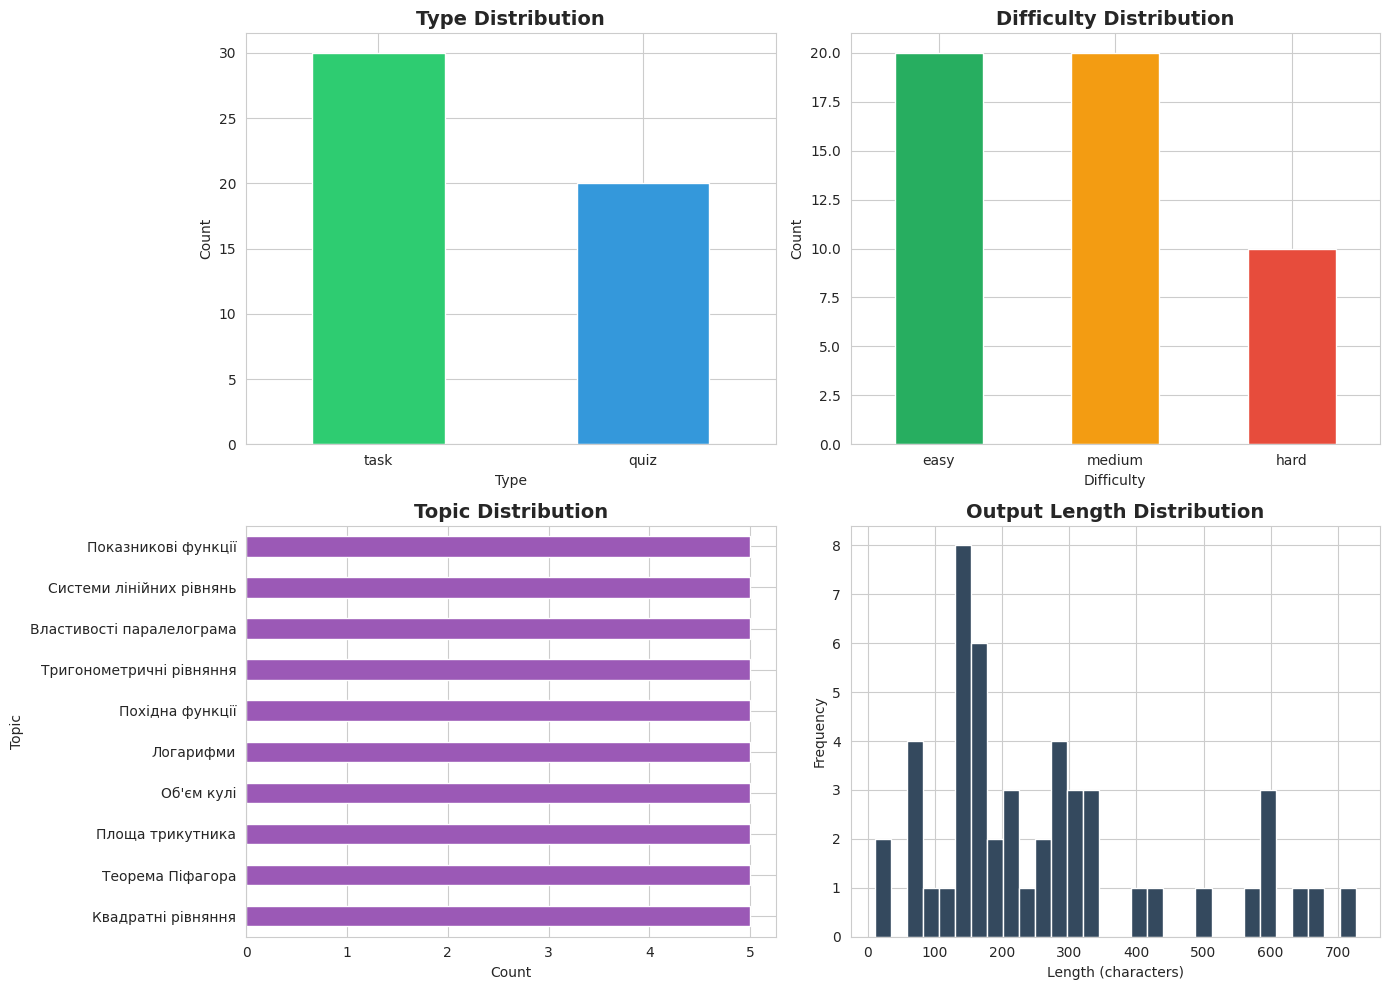

In [20]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Type distribution
evaluation_df['type'].value_counts().plot(kind='bar', ax=axes[0, 0], color=['#2ecc71', '#3498db'])
axes[0, 0].set_title('Type Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Type')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=0)

# Difficulty distribution
evaluation_df['difficulty'].value_counts().plot(kind='bar', ax=axes[0, 1], color=['#27ae60', '#f39c12', '#e74c3c'])
axes[0, 1].set_title('Difficulty Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Difficulty')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=0)

# Topic distribution
evaluation_df['input'].value_counts().plot(kind='barh', ax=axes[1, 0], color='#9b59b6')
axes[1, 0].set_title('Topic Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Count')
axes[1, 0].set_ylabel('Topic')

# Output length distribution
evaluation_df['output'].str.len().hist(bins=30, ax=axes[1, 1], color='#34495e', edgecolor='white')
axes[1, 1].set_title('Output Length Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Length (characters)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
viz_path = OUTPUT_DIR / "dataset_visualization.png"
plt.savefig(viz_path, dpi=150, bbox_inches='tight')
print(f" Saved visualization: {viz_path}")
plt.show()

## 13. Sample Outputs

Display sample tasks and quizzes from the dataset.

In [21]:
# Show sample task
sample_task = evaluation_df[evaluation_df['type'] == 'task'].iloc[0]

print("="*80)
print("SAMPLE TASK")
print("="*80)
print(f"\nТема: {sample_task['input']}")
print(f"Складність: {sample_task['difficulty']}")
print(f"\nЗАДАЧА:\n{sample_task['output']}")
if 'solution' in sample_task:
    print(f"\nРОЗВ'ЯЗАННЯ:\n{sample_task['solution']}")
print(f"\nВІДПОВІДЬ:\n{sample_task['expected_answer']}")

SAMPLE TASK

Тема: Квадратні рівняння
Складність: easy

ЗАДАЧА:
На фермі мешкає 5 корів і 3 свині. Всі тварини разом важать 520 кг. 
Одна корова важить на 100 кг більше, ніж одна свиня. Скільки важить одна корова?



## РОЗВЯЗАННЯ:

1. **Нехай x - це вага однієї свині.**

2. **Вага однієї корови дорівнює x + 100 кг.**

3. **Загальна вага 5 корів:** 5(x + 100) = 5x + 500 кг

4. **Загальна вага 3 свиней:** 3x 

5. **Сума ваги всіх тварин:** 5x + 500 + 3x = 520

6. **Зводимо подібні члени:** 8x + 500 = 520

7. **Віднімаємо 500 з обох сторін рівняння:** 8x = 20

8. **Ділимо обидві сторони на 8:** x = 2.5

9. **Вага однієї корови:** 2.5 + 100 = 102.5 кг



## ВІДПОВІДЬ:

Одна корова важить 102.5 кг.

РОЗВ'ЯЗАННЯ:


ВІДПОВІДЬ:
5


In [22]:
# Show sample quiz
sample_quiz = evaluation_df[evaluation_df['type'] == 'quiz'].iloc[0]

print("="*80)
print("SAMPLE QUIZ")
print("="*80)
print(f"\nТема: {sample_quiz['input']}")
print(f"Складність: {sample_quiz['difficulty']}")
print(f"\n{sample_quiz['output']}")
print(f"\nПравильна відповідь: {sample_quiz['expected_answer']}")
if 'explanation' in sample_quiz:
    print(f"\nПояснення: {sample_quiz['explanation']}")

SAMPLE QUIZ

Тема: Квадратні рівняння
Складність: easy

Яку з наведених систем рівнянь можна побудувати на основі віршованої задачі про площі двох квадратів?
A) * x + y = 136
  * x * y = 25
B) * x^2 + y^2 = 136
  * y = x + 5
C) * x + 5 = y
  * x^2 + y^2 = 136
D) * x^2 = y
  * x + 5 = y


Правильна відповідь: C) * x + 5 = y
  * x^2 + y^2 = 136

Пояснення: Правильна відповідь - **C).** 

*  **x + 5 = y** відображає інформацію про те, що сторона другого квадрату дорівнює стороні першого квадрату плюс 5.
*  **x^2 + y^2 = 136** відображає факт, що сума площ двох квадратів дорівнює 136.

Інші варіанти неправильні через різні формулювання рівнянь.  Варіант A не враховує зв'язок між сторонами квадратів, варіант B  помилково використовує рівняння суми координат, а варіант D не відображає суму площ квадратів.


## Summary

### What We Built

1. **MathTaskGenerator** - Generates math problems with solutions based on topic input
2. **MathQuizGenerator** - Creates multiple-choice quizzes with plausible distractors
3. **Multi-Agent System** - Advanced architecture with verification (Planning, Generator, Verifier, Difficulty agents)
4. **Wolfram Alpha Verification** - External verification of answers using Wolfram Alpha API
5. **Evaluation Dataset** - JSONL file with ground-truth verified answers

### Assignment Requirements Met

✓ Task generation based on topic input
✓ Quiz generation with multiple-choice questions
✓ Solutions and answers for generated content
✓ Evaluation dataset in JSONL format with ground-truth answers
✓ All outputs in Ukrainian
✓ Beyond basic RAG (multi-agent system + external verification)

### Verification Strategy

**Ground Truth Generation:**
- LLM generates task with answer
- Wolfram Alpha verifies numerical answer
- Retry loop (up to 3 attempts) until verified
- Dataset stores both:
  - `expected_answer`: Wolfram Alpha result (ground truth)
  - `generated_answer`: LLM's answer (to evaluate)
  - `verification_status`: verified/unverified/failed

**Evaluation Approach:**
- Compare LLM-generated answers with Wolfram-verified ground truth
- Measure correctness, not just quality
- Filter verified vs unverified entries for analysis

### Dataset Statistics

- Total entries: 50 (10 topics × 5 entries each)
- Tasks: 30 (3 per topic with varying difficulty)
  - Verified tasks: Depends on Wolfram API success rate
  - Unverified tasks: Fallback when verification fails
- Quizzes: 20 (2 per topic, no numerical verification needed)
- Format: JSONL with required fields (input, output, type, expected_answer, generated_answer, verification_status)

### Files Generated

- `evaluation_dataset.jsonl` - Main evaluation dataset (assignment requirement)
- `evaluation_dataset.csv` - Same data in CSV format
- `dataset_summary.json` - Statistics and metadata
- `dataset_visualization.png` - Distribution charts

### Setup Requirements

**Environment Variables:**
Set `WOLFRAM_APP_ID` in `.env` file or environment:
```bash
export WOLFRAM_APP_ID="YOUR-APP-ID-HERE"
```

Get free App ID at: https://developer.wolframalpha.com/portal/myapps/

### Next Steps

1. **Run with Wolfram verification** - Generate verified dataset
2. **Analyze verification success rate** - How many tasks get verified?
3. **Improve extraction** - Better regex for Ukrainian math expressions
4. **Expand dataset** - Generate more examples (100+)
5. **Evaluate correctness** - Compare LLM vs Wolfram answers